Gán nhãn cho các file

In [1]:
import os

def rename_files_recursive(root_folder):
    mapping_data = {
        "M4_1": "12,704",
        "M4_2": "19,639",
        "M4_3": "40,769",
        "M4_4": "25,829",
        "M4_5": "3,879",
        "M4_6": "26,704",
        "M4_7": "4,310",

        "M8_1": "10,792",
        "M8_2": "18,861",
        "M8_3": "8,005",
        "M8_4": "3,889",
        "M8_5": "45,273",
        "M8_7": "23,333",

        "M9_2": "6,644",
        "M9_3": "8,977",
        "M9_4": "21,194",

        "M10_1": "7,032",
        "M10_2": "10,856",
        "M10_3": "8,167",
        "M10_4": "7,421",
        "M10_5": "7,745",
        "M10_6": "10,144",
        "M10_7": "6,708",
        "M10_8": "13,579"
    }
    print(f"Đang quét toàn bộ thư mục: {root_folder}...\n")

    count_renamed = 0

    for current_dir, dirs, files in os.walk(root_folder):
        for filename in files:
            if not filename.endswith('.txt'):
                continue
            for sample_id, label_value in mapping_data.items():
                prefix_check = sample_id + " "

                if filename.startswith(prefix_check):
                    label_str = f"({label_value})"
                    if label_str in filename:
                        continue # Bỏ qua nếu đã đổi tên rồi

                    # Tạo đường dẫn cũ và mới
                    old_path = os.path.join(current_dir, filename)

                    name_part, ext = os.path.splitext(filename)
                    new_filename = f"{name_part} {label_str}{ext}"
                    new_path = os.path.join(current_dir, new_filename)

                    try:
                        os.rename(old_path, new_path)
                        short_dir = os.path.relpath(current_dir, root_folder)
                        print(f"[{short_dir}] {filename} \n      -> {new_filename}")
                        count_renamed += 1
                    except Exception as e:
                        print(f" Lỗi: {e}")

                    break # Đã tìm thấy ID khớp

    print(f"\nHoàn tất! Đã xử lý {count_renamed} file.")


rename_files_recursive("/content/drive/MyDrive/Tomato/M4,8,9,10_raman")

Đang quét toàn bộ thư mục: /content/drive/MyDrive/Tomato/M4,8,9,10_raman...


Hoàn tất! Đã xử lý 0 file.


Bỏ các file không được gán nhãn

In [2]:
import os

def delete_unlabeled_files(root_folder):
    print(f" Đang quét và XÓA file 'không nhãn' hoặc 'short/sort range' trong: {root_folder}...\n")

    count_deleted = 0

    for current_dir, dirs, files in os.walk(root_folder):

        for filename in files:

            # Chỉ xử lý file .txt
            if not filename.lower().endswith('.txt'):
                continue

            file_path = os.path.join(current_dir, filename)
            filename_lower = filename.lower()

            # ---- LOGIC KIỂM TRA ----
            has_label = '(' in filename and ')' in filename

            # Phát hiện short-range hoặc sort-range
            has_short_range = (
                "short range" in filename_lower or
                "sort range" in filename_lower
            )

            # Điều kiện xóa
            need_delete = (not has_label) or has_short_range

            if need_delete:
                try:
                    os.remove(file_path)
                    short_dir = os.path.relpath(current_dir, root_folder)

                    # Lý do xoá
                    reason = []
                    if not has_label:
                        reason.append("không nhãn")
                    if has_short_range:
                        reason.append("short range")

                    print(f"Đã xóa: [{short_dir}] {filename}  → Lý do: {', '.join(reason)}")
                    count_deleted += 1

                except Exception as e:
                    print(f"Lỗi khi xóa {filename}: {e}")

    print(f"\n Hoàn tất! Đã xóa vĩnh viễn {count_deleted} file.")

delete_unlabeled_files("/content/drive/MyDrive/Tomato/M4,8,9,10_raman")


 Đang quét và XÓA file 'không nhãn' hoặc 'short/sort range' trong: /content/drive/MyDrive/Tomato/M4,8,9,10_raman...


 Hoàn tất! Đã xóa vĩnh viễn 0 file.


Sort theo thông số kĩ thuật

In [3]:
import os
import shutil
import re

def organize_by_wavelength_only(source_folder, destination_folder):
    """
    Quét toàn bộ thư mục con (M4, M8...), lấy file ra và chỉ phân loại theo bước sóng kích thích.
    """

    # Tạo thư mục đích lớn nếu chưa có
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    print(f"Đang quét dữ liệu trong: '{source_folder}'...")

    count_moved = 0

    for current_root, dirs, files in os.walk(source_folder):
        if os.path.abspath(destination_folder) in os.path.abspath(current_root):
            continue

        for filename in files:
            # Chỉ xử lý file .txt
            if not filename.endswith('.txt'):
                continue

            # 1. Tìm bước sóng kích thích
            match = re.search(r'(Ex\d+)', filename)

            if match:
                excitation_folder = match.group(1) 
            else:
                excitation_folder = "Unknown_Ex"   # Nếu file không ghi bước sóng

            # 2. Tạo thư mục đích
            # Cấu trúc: Sorted / Bước sóng 
            target_dir = os.path.join(destination_folder, excitation_folder)

            if not os.path.exists(target_dir):
                os.makedirs(target_dir)

            # 3. Di chuyển file
            src_path = os.path.join(current_root, filename)
            dst_path = os.path.join(target_dir, filename)

            # Xử lý trường hợp trùng tên file (nếu 2 mẫu khác nhau có cùng tên file)
            if os.path.exists(dst_path):
                base, ext = os.path.splitext(filename)
                counter = 1
                while os.path.exists(dst_path):
                    dst_path = os.path.join(target_dir, f"{base}_copy{counter}{ext}")
                    counter += 1

            try:
                shutil.move(src_path, dst_path)
                print(f"-> Moved: {filename} vào {excitation_folder}")
                count_moved += 1
            except Exception as e:
                print(f"Lỗi khi chuyển file {filename}: {e}")

    # 4. Xóa thư mục rỗng
    for current_root, dirs, files in os.walk(source_folder, topdown=False):
        if not os.listdir(current_root) and current_root != source_folder:
            try:
                # Không xóa folder đích nếu nó nằm trong nguồn
                if os.path.abspath(current_root) != os.path.abspath(destination_folder):
                    os.rmdir(current_root)
            except:
                pass

    print(f"\ Hoàn tất! Đã phân loại {count_moved} file theo bước sóng.")

source_path = "./M4,8,9,10_raman"
dest_path = "./M4,8,9,10_raman/sorted"
organize_by_wavelength_only(source_path, dest_path)

Đang quét dữ liệu trong: './M4,8,9,10_raman'...
\ Hoàn tất! Đã phân loại 0 file theo bước sóng.


Vẽ toàn bộ phổ

Tìm thấy 33 file '532'. Đang vẽ...


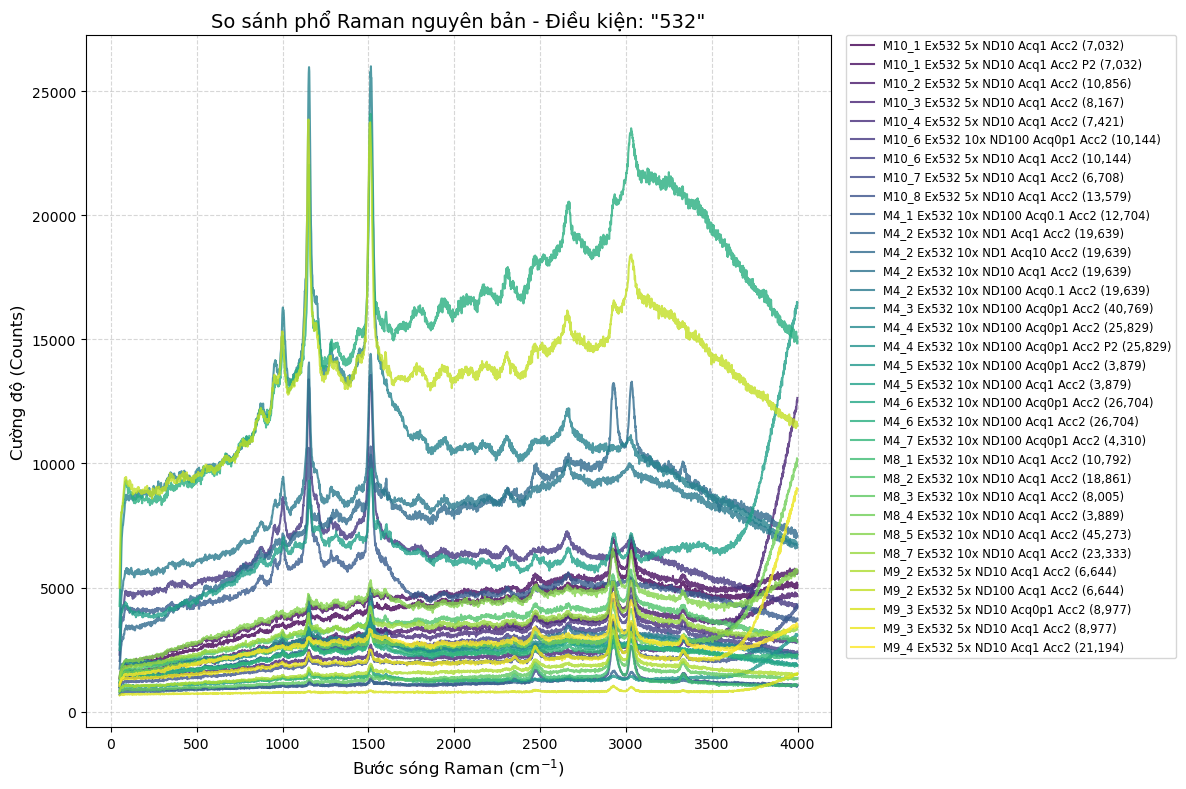

Tìm thấy 25 file '633'. Đang vẽ...


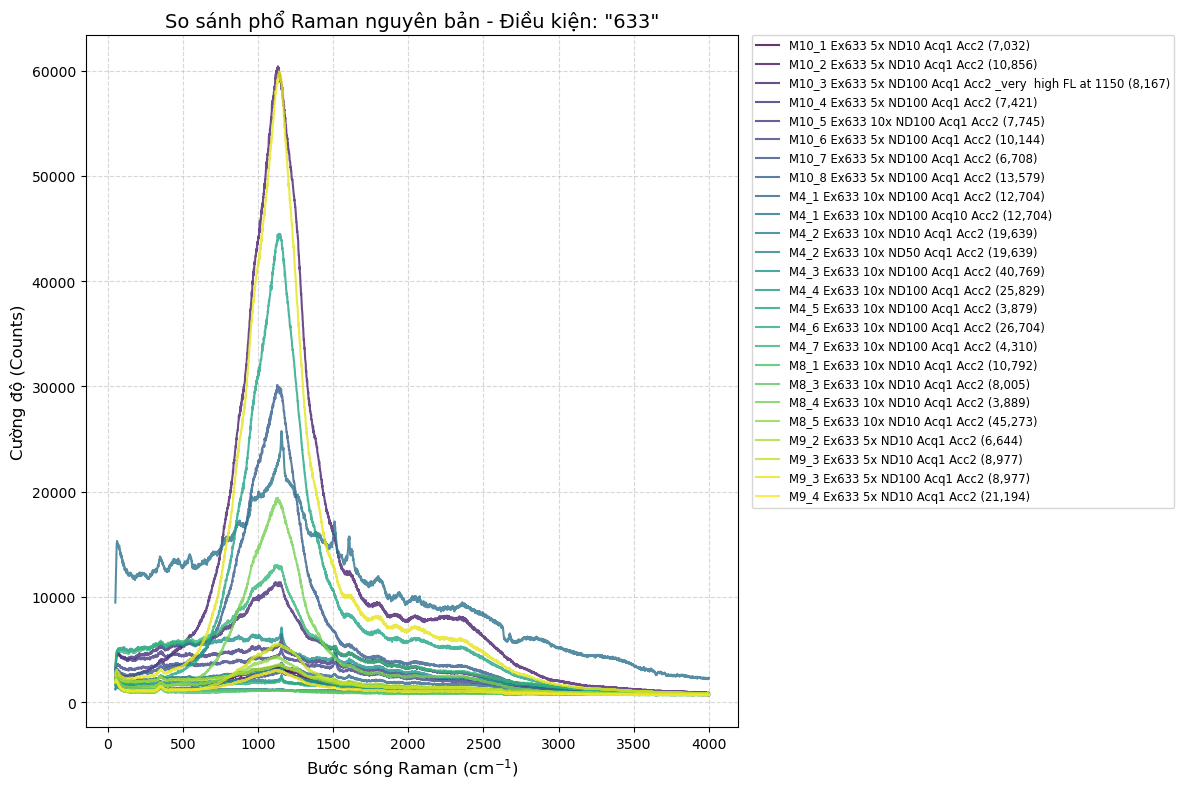

Tìm thấy 6 file '785'. Đang vẽ...


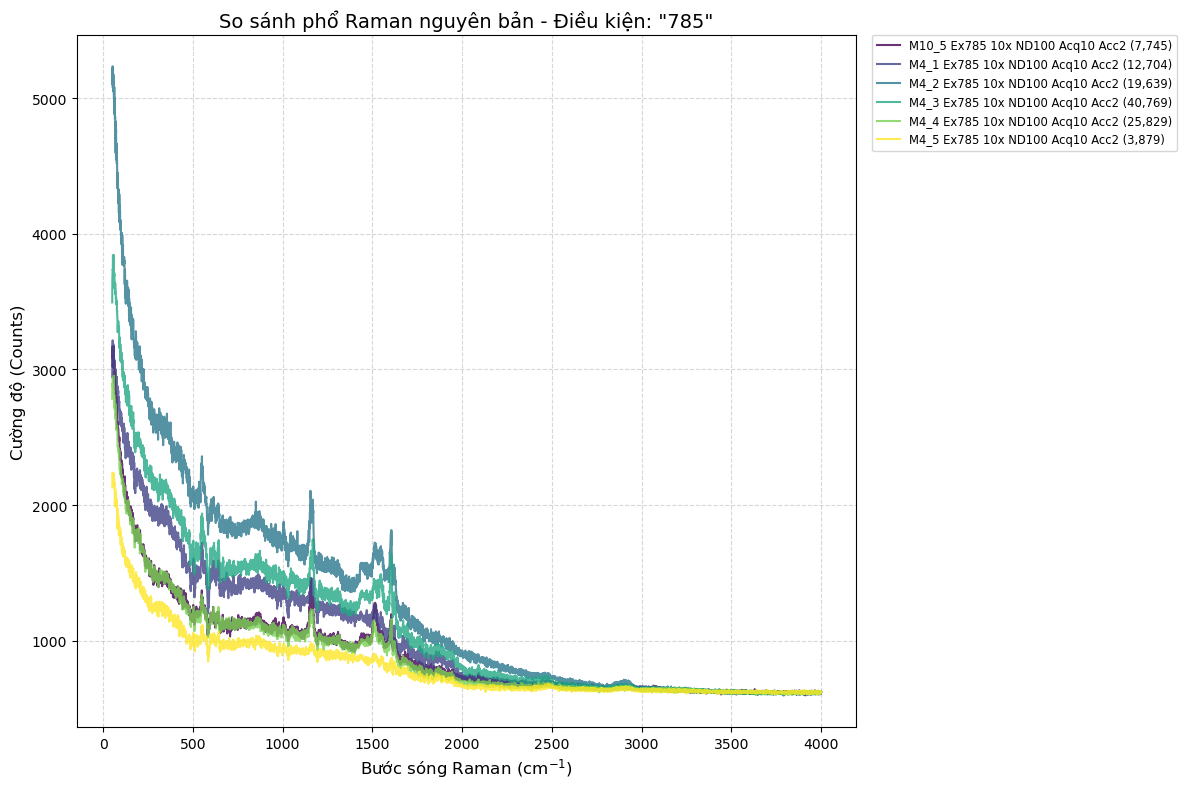

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def plot_spectra_raw(root_folder, condition_keyword):
    """
    Vẽ tất cả các file phổ có tên chứa 'condition_keyword' giữ nguyên giá trị cường độ gốc.

    Tham số:
    - root_folder: Thư mục chứa file.
    - condition_keyword:
    """

    # Thiết lập kích thước biểu đồ
    plt.figure(figsize=(12, 8))

    # 1. Quét và tìm file
    found_files = []
    for current_dir, _, files in os.walk(root_folder):
        for filename in files:
            if filename.endswith('.txt') and condition_keyword in filename:
                full_path = os.path.join(current_dir, filename)
                found_files.append((filename, full_path))

    if not found_files:
        print(f"Không tìm thấy file nào chứa từ khóa '{condition_keyword}'!")
        return

    print(f"Tìm thấy {len(found_files)} file '{condition_keyword}'. Đang vẽ...")

    # Sắp xếp tên file theo thứ tự bảng chữ cái
    found_files.sort()

    colors = cm.viridis(np.linspace(0, 1, len(found_files)))

    # 2. Vẽ từng file
    for i, (filename, filepath) in enumerate(found_files):
        try:
            # Đọc dữ liệu 
            df = pd.read_csv(filepath, sep='\s+', header=None, engine='python')

            # Cột 0 là Wavenumber, Cột 1 là Intensity
            x = df[0]
            y = df[1]

            # Làm gọn tên label
            label_name = filename.replace(".txt", "")

            # Vẽ phổ gốc
            plt.plot(x, y, label=label_name, color=colors[i], linewidth=1.5, alpha=0.8)

        except Exception as e:
            print(f"Lỗi khi đọc file {filename}: {e}")

    # 3. Trang trí biểu đồ
    plt.xlabel('Bước sóng Raman $(\mathrm{cm}^{-1})$', fontsize=12)
    plt.ylabel('Cường độ (Counts)', fontsize=12)
    plt.title(f'So sánh phổ Raman nguyên bản - Điều kiện: "{condition_keyword}"', fontsize=14)

    plt.grid(True, linestyle='--', alpha=0.5)

    # Đưa chú thích (Legend) ra bên ngoài để không che mất phổ
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize='small')

    plt.tight_layout()
    plt.show()


my_folder = r"./M4,8,9,10_raman/sorted"

plot_spectra_raw(my_folder, "532")
plot_spectra_raw(my_folder, "633")
plot_spectra_raw(my_folder, "785")

Vẽ 1 phổ để kiểm tra

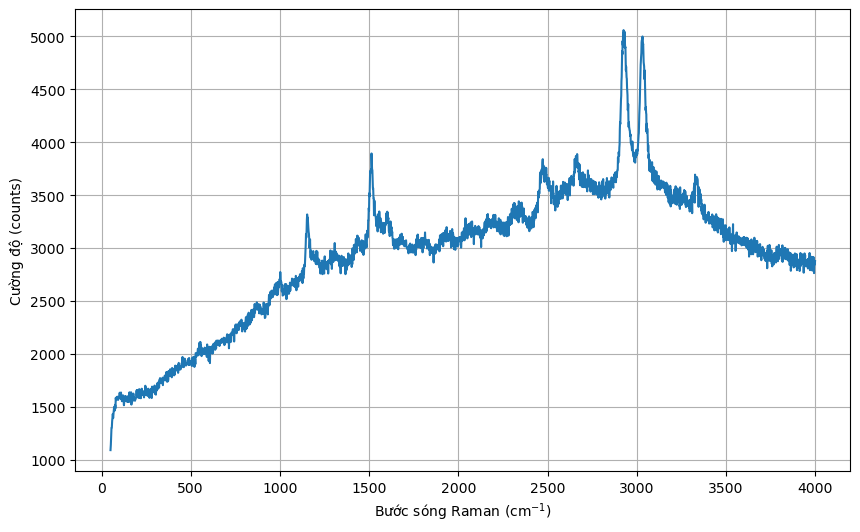

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = "M4,8,9,10_raman\sorted\Ex532\M10_4 Ex532 5x ND10 Acq1 Acc2 (7,421).txt"
df = pd.read_csv(file_path, sep='\s+', header=None, skiprows=0)

df.columns = ['Wavenumber', 'Intensity']

# Vẽ phổ Raman
plt.figure(figsize=(10, 6))
plt.plot(df['Wavenumber'], df['Intensity'], label='Phổ Raman')
# Sử dụng ký hiệu LaTeX cho đơn vị Wavenumber
plt.xlabel('Bước sóng Raman $(\mathrm{cm}^{-1})$')
plt.ylabel('Cường độ (counts)')
plt.grid(True)

plt.show()

In [ ]:
Vẽ 2 phổ để so sánh

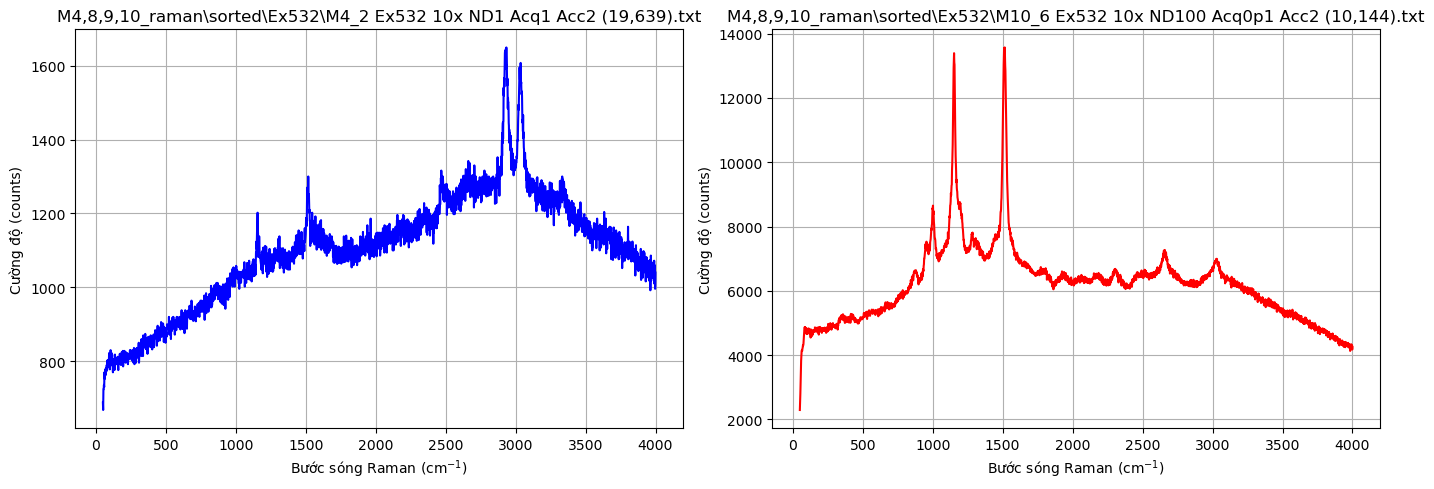

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

file_path_1 = r"M4,8,9,10_raman\sorted\Ex532\M4_2 Ex532 10x ND1 Acq1 Acc2 (19,639).txt"
file_path_2 = r"M4,8,9,10_raman\sorted\Ex532\M10_6 Ex532 10x ND100 Acq0p1 Acc2 (10,144).txt"

def load_spectrum(path):
    df = pd.read_csv(path, sep=r'\s+', header=None)
    df.columns = ['Wavenumber', 'Intensity']
    return df

df1 = load_spectrum(file_path_1)
df2 = load_spectrum(file_path_2)

# ==== VẼ 2 PHỔ CẠNH NHAU ====
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot file 1
axes[0].plot(df1['Wavenumber'], df1['Intensity'], color='blue')
axes[0].set_title(file_path_1)
axes[0].set_xlabel('Bước sóng Raman $(\mathrm{cm}^{-1})$')
axes[0].set_ylabel('Cường độ (counts)')
axes[0].grid(True)

# Plot file 2
axes[1].plot(df2['Wavenumber'], df2['Intensity'], color='red')
axes[1].set_title(file_path_2)
axes[1].set_xlabel('Bước sóng Raman $(\mathrm{cm}^{-1})$')
axes[1].set_ylabel('Cường độ (counts)')
axes[1].grid(True)

plt.tight_layout()
plt.show()

Vẽ phổ theo điều kiện

Loaded: M9_2 Ex532 5x ND10 Acq1 Acc2 (6,644).txt
Loaded: M9_2 Ex532 5x ND100 Acq1 Acc2 (6,644).txt


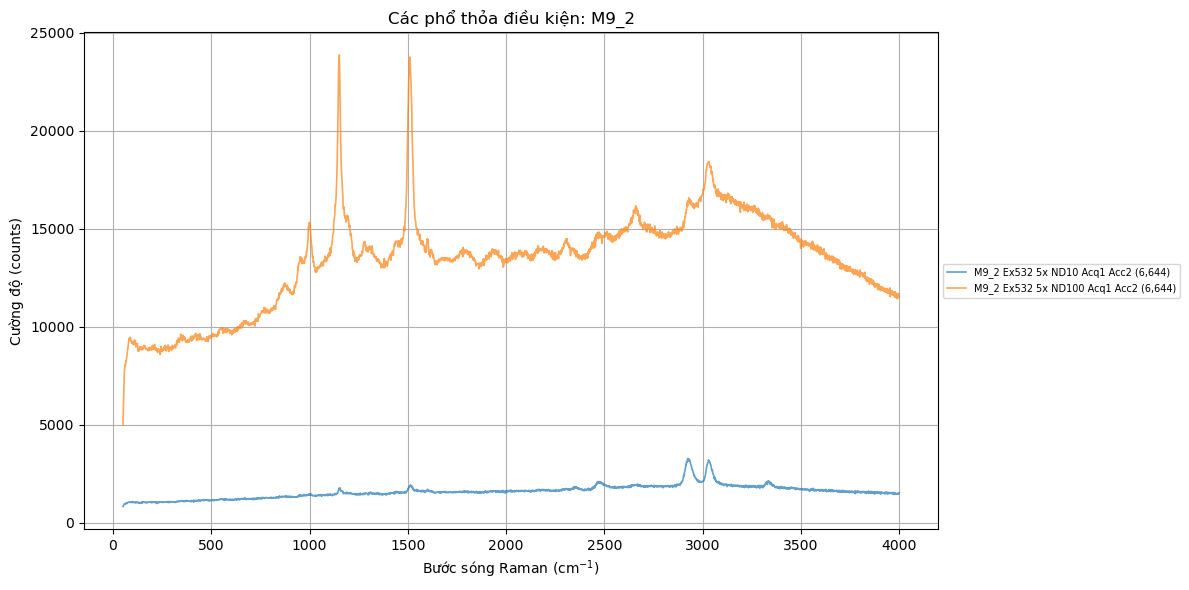

In [8]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

folder_path = r"M4,8,9,10_raman\sorted\Ex532"
conditions = [
    "M9_2",
]

def match_conditions(filename, conditions):
    """True nếu filename chứa TẤT CẢ chuỗi trong conditions."""
    filename_lower = filename.lower()
    return all(cond.lower() in filename_lower for cond in conditions)


plt.figure(figsize=(12, 6))
legend_names = []  # để lưu tên file rút gọn


count = 0
for root, _, files in os.walk(folder_path):
    for file in files:
        if file.endswith(".txt") and match_conditions(file, conditions):
            
            full_path = os.path.join(root, file)
            try:
                df = pd.read_csv(full_path, sep=r"\s+", header=None)
                df.columns = ['Wavenumber', 'Intensity']
                
                plt.plot(df['Wavenumber'], df['Intensity'], alpha=0.7, linewidth=1.2)

                short_name = file.replace(".txt", "")
                legend_names.append(short_name)
                count += 1
                print(f"Loaded: {file}")
                
            except Exception as e:
                print(f" Lỗi đọc file {file}: {e}")


if count > 0:
    plt.xlabel('Bước sóng Raman $(\mathrm{cm}^{-1})$')
    plt.ylabel('Cường độ (counts)')
    plt.title(f"Các phổ thỏa điều kiện: {', '.join(conditions)}")
    plt.grid(True)
    plt.legend(
        legend_names,
        fontsize=7,
        loc='center left',
        bbox_to_anchor=(1, 0.5)
    )

    plt.tight_layout()
    plt.show()
else:
    print(" Không tìm thấy file thỏa điều kiện!")


Vẽ phổ ngoại lai
Theo quan sát có 2 loại phổ lên và xuống ở đuôi, vẽ 2 loại này để xác đinh vì sao có sự khác biệt

--- PHÂN TÍCH XU HƯỚNG VÙNG 3500-4000 cm-1 ---


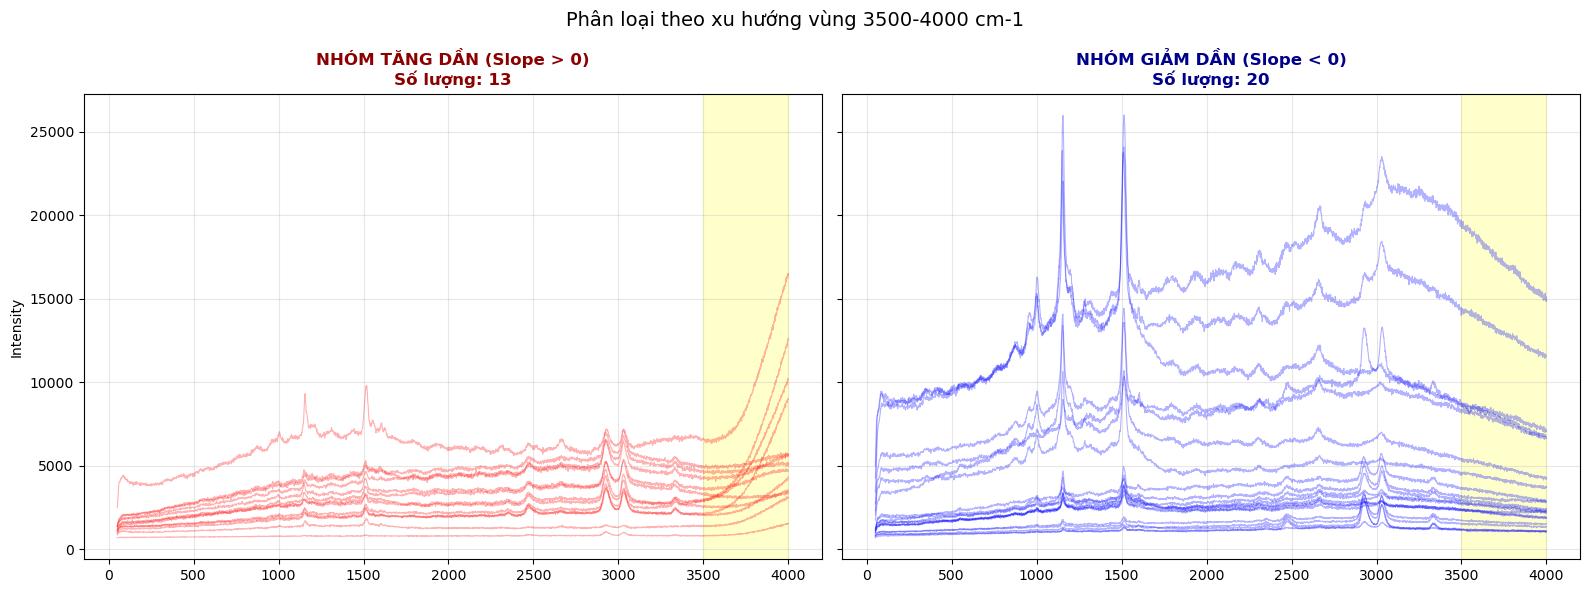

(['M10_1 Ex532 5x ND10 Acq1 Acc2 (7,032).txt',
  'M10_1 Ex532 5x ND10 Acq1 Acc2 P2 (7,032).txt',
  'M10_2 Ex532 5x ND10 Acq1 Acc2 (10,856).txt',
  'M10_3 Ex532 5x ND10 Acq1 Acc2 (8,167).txt',
  'M10_8 Ex532 5x ND10 Acq1 Acc2 (13,579).txt',
  'M4_5 Ex532 10x ND100 Acq0p1 Acc2 (3,879).txt',
  'M4_5 Ex532 10x ND100 Acq1 Acc2 (3,879).txt',
  'M8_4 Ex532 10x ND10 Acq1 Acc2 (3,889).txt',
  'M8_5 Ex532 10x ND10 Acq1 Acc2 (45,273).txt',
  'M8_7 Ex532 10x ND10 Acq1 Acc2 (23,333).txt',
  'M9_3 Ex532 5x ND10 Acq0p1 Acc2 (8,977).txt',
  'M9_3 Ex532 5x ND10 Acq1 Acc2 (8,977).txt',
  'M9_4 Ex532 5x ND10 Acq1 Acc2 (21,194).txt'],
 ['M10_4 Ex532 5x ND10 Acq1 Acc2 (7,421).txt',
  'M10_6 Ex532 10x ND100 Acq0p1 Acc2 (10,144).txt',
  'M10_6 Ex532 5x ND10 Acq1 Acc2 (10,144).txt',
  'M10_7 Ex532 5x ND10 Acq1 Acc2 (6,708).txt',
  'M4_1 Ex532 10x ND100 Acq0.1 Acc2 (12,704).txt',
  'M4_2 Ex532 10x ND1 Acq1 Acc2 (19,639).txt',
  'M4_2 Ex532 10x ND1 Acq10 Acc2 (19,639).txt',
  'M4_2 Ex532 10x ND10 Acq1 Acc2 (19,

In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def classify_trend_roi(root_folder, condition_keyword, start_wave, end_wave):
    """
    Phân loại phổ thành 2 nhóm (Tăng dần / Giảm dần) dựa trên độ dốc của vùng ROI.
    """

    print(f"--- PHÂN TÍCH XU HƯỚNG VÙNG {start_wave}-{end_wave} cm-1 ---")

    # Danh sách lưu kết quả
    group_increasing = [] # Nhóm tăng
    group_decreasing = [] # Nhóm giảm

    # 1. Quét file
    found_files = []
    for current_dir, _, files in os.walk(root_folder):
        for filename in files:
            if filename.endswith('.txt') and condition_keyword in filename:
                full_path = os.path.join(current_dir, filename)
                found_files.append(full_path)

    if not found_files:
        print("Không tìm thấy file nào!")
        return

    # 2. Xử lý từng file
    for filepath in found_files:
        try:
            df = pd.read_csv(filepath, sep='\s+', header=None, engine='python')
            x = df[0].values
            y = df[1].values

            # --- CẮT DỮ LIỆU TRONG VÙNG ROI ---
            # Chỉ lấy các điểm nằm trong khoảng start_wave -> end_wave
            mask = (x >= start_wave) & (x <= end_wave)
            x_roi = x[mask]
            y_roi = y[mask]

            if len(x_roi) < 2:
                print(f"Bỏ qua {os.path.basename(filepath)}: Không đủ dữ liệu trong vùng chọn.")
                continue

            # --- TÍNH ĐỘ DỐC (SLOPE) ---
            # Hồi quy tuyến tính bậc 1: y = ax + b. (a là slope)
            slope, intercept = np.polyfit(x_roi, y_roi, 1)

            # Lưu thông tin để vẽ
            file_info = {
                'name': os.path.basename(filepath),
                'x': x,         # Toàn bộ phổ
                'y': y,
                'x_roi': x_roi, # Vùng dùng để tính toán
                'y_fit': slope * x_roi + intercept, # Đường trendline (để vẽ kiểm chứng)
                'slope': slope
            }

            # Phân loại
            if slope > 0:
                group_increasing.append(file_info)
            else:
                group_decreasing.append(file_info)

        except Exception as e:
            print(f"Lỗi đọc file: {e}")

    # 3. VẼ BIỂU ĐỒ (2 Subplots)
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

    # --- Biểu đồ 1: Nhóm Tăng (Increasing) ---
    ax1 = axes[0]
    for item in group_increasing:
        # Vẽ phổ gốc (mờ)
        ax1.plot(item['x'], item['y'], color='red', alpha=0.3, linewidth=0.8)

    ax1.set_title(f"NHÓM TĂNG DẦN (Slope > 0)\nSố lượng: {len(group_increasing)}", color='darkred', fontweight='bold')
    ax1.axvspan(start_wave, end_wave, color='yellow', alpha=0.2, label='Vùng xét duyệt')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylabel("Intensity")

    # --- Biểu đồ 2: Nhóm Giảm (Decreasing) ---
    ax2 = axes[1]
    for item in group_decreasing:
        # Vẽ phổ gốc
        ax2.plot(item['x'], item['y'], color='blue', alpha=0.3, linewidth=0.8)

    ax2.set_title(f"NHÓM GIẢM DẦN (Slope < 0)\nSố lượng: {len(group_decreasing)}", color='darkblue', fontweight='bold')
    ax2.axvspan(start_wave, end_wave, color='yellow', alpha=0.2)
    ax2.grid(True, alpha=0.3)

    plt.suptitle(f"Phân loại theo xu hướng vùng {start_wave}-{end_wave} cm-1", fontsize=14)
    plt.tight_layout()
    plt.show()

    # Trả về danh sách tên file nếu cần dùng tiếp
    return [item['name'] for item in group_increasing], [item['name'] for item in group_decreasing]

my_folder = r"./M4,8,9,10_raman/sorted"
classify_trend_roi(my_folder, "532", start_wave=3500, end_wave=4000)

-> Sự khác nhau là do các mẫu cà chua khác nhau, tuy nhiên loại nào cũng có những phổ có đoạn đuôi bị đi lên như vậy
- Theo tài liệu việc Xác định Carotenoid: Các dải Raman đặc trưng cho carotenoid đã được xác định rõ, bao gồm các dao động chính ν₁ (C=C stretching) ở ~1520 cm⁻¹, ν₂ (C-C stretching) ở ~1156 cm⁻¹, và ν₃ (C-CH₃ stretching) ở ~1007 cm⁻¹.

-> Với các phổ đã phân loại ta thấy rõ ràng hơn về điều này

Xem phân phối nhãn

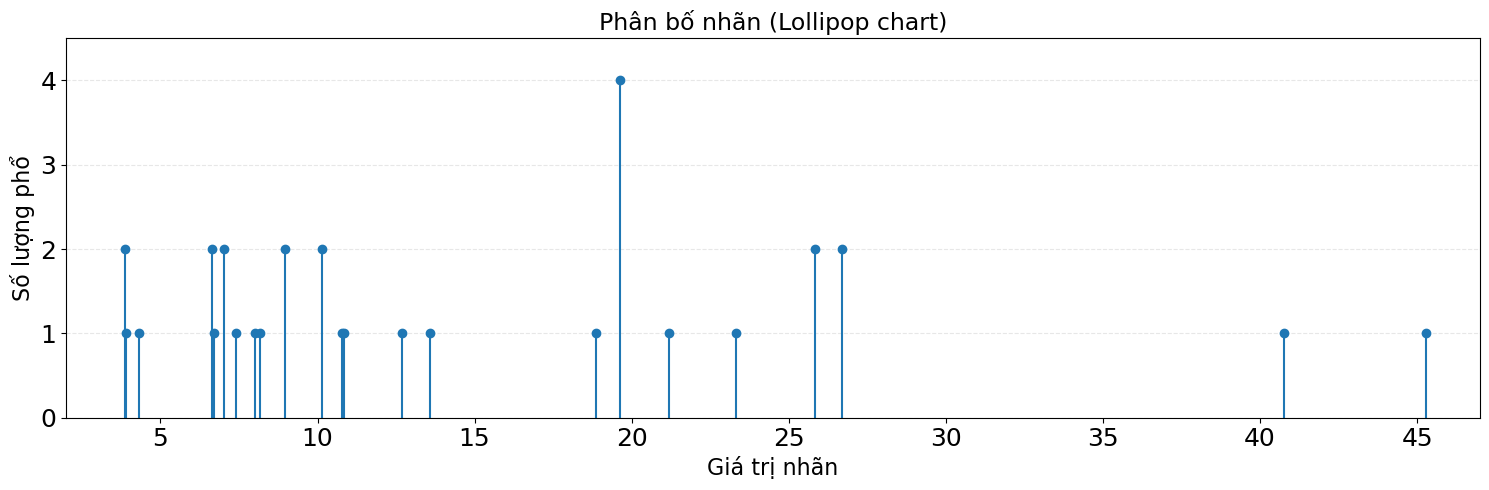

In [34]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

def plot_label_lollipop(root_folder, xtick_step=5, ytick_step=1):
    labels = []
    pattern = re.compile(r'\(\s*([\d\.,]+)\s*\)')

    # 1. Thu thập nhãn
    for _, _, files in os.walk(root_folder):
        for f in files:
            if f.endswith(".txt"):
                m = pattern.search(f)
                if m:
                    try:
                        labels.append(float(m.group(1).replace(',', '.')))
                    except:
                        pass

    labels = np.array(labels)
    unique_labels, counts = np.unique(labels, return_counts=True)

    plt.figure(figsize=(15, 5))

    # 2. Lollipop chart
    plt.stem(
        unique_labels,
        counts,
        basefmt=" ",
        linefmt='C0-',
        markerfmt='C0o'
    )

    # 3. Trục X — BỎ tick 0
    xmin = int(np.floor(unique_labels.min()))
    xmax = int(np.ceil(unique_labels.max()))
    plt.xticks(
        np.arange(xtick_step, xmax + 1, xtick_step),
        fontsize=18
    )
    plt.xlim(xmin - 1, xmax + 1)

    # 4. Trục Y — giữ 0
    ymax = int(counts.max())
    plt.yticks(
        np.arange(0, ymax + 1, ytick_step),
        fontsize=18
    )
    plt.ylim(0, ymax + 0.5)

    plt.xlabel("Giá trị nhãn", fontsize=16)
    plt.ylabel("Số lượng phổ", fontsize=16)
    plt.title("Phân bố nhãn (Lollipop chart)", fontsize=17)

    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()


folder_path = r"./M4,8,9,10_raman/sorted/Ex532"
plot_label_lollipop(folder_path, xtick_step=5, ytick_step=1)


Chia 3 khoảng nhãn

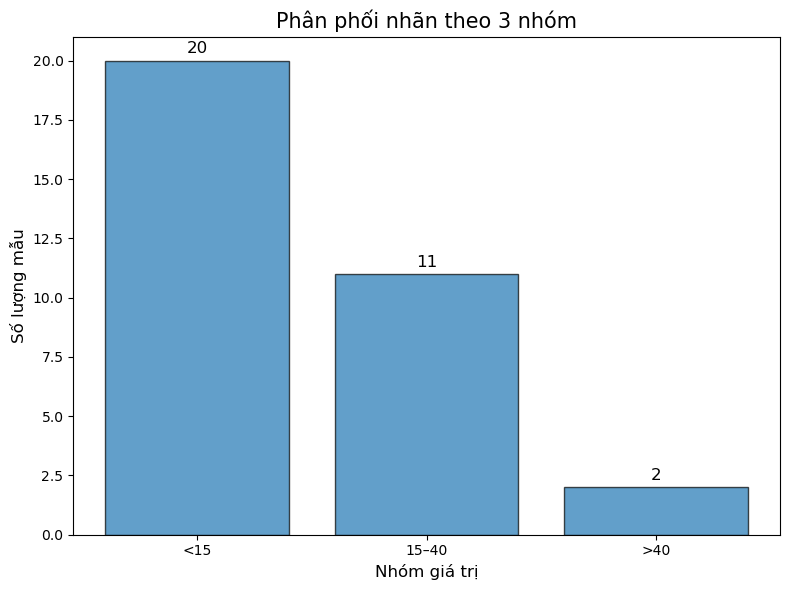


=== THỐNG KÊ NHÓM ===
<15: 20 mẫu
15–40: 11 mẫu
>40: 2 mẫu


In [ ]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

def load_labels(root_folder):
    """
    Quét folder và trích giá trị nhãn dạng số nằm trong dấu ngoặc ( ... )
    Trả về list labels dạng float theo đúng thứ tự file đọc được.
    """
    labels = []
    pattern = re.compile(r'\(\s*([\d\.,]+)\s*\)')  

    for current_dir, _, files in os.walk(root_folder):
        for filename in sorted(files):   # sorted để cố định thứ tự
            if filename.endswith(".txt"):
                match = pattern.search(filename)
                if match:
                    try:
                        val_str = match.group(1).replace(',', '.')
                        labels.append(float(val_str))
                    except:
                        pass

    if not labels:
        print("Không tìm thấy nhãn!")

    return np.array(labels)


def plot_3groups(labels):
    """
    Nhận vào labels (mảng giá trị số) và vẽ histogram theo 3 nhóm:
    <15, 15–40, >40
    """
    if labels is None or len(labels) == 0:
        print("labels rỗng — không thể vẽ!")
        return

    bins = [0, 15, 40, labels.max() + 1]
    group_names = ["<15", "15–40", ">40"]

    groups = np.digitize(labels, bins, right=True)

    counts = {name: (groups == idx+1).sum() for idx, name in enumerate(group_names)}

    plt.figure(figsize=(8, 6))
    plt.bar(counts.keys(), counts.values(), alpha=0.7, edgecolor='black')

    plt.title("Phân phối nhãn theo 3 nhóm", fontsize=15)
    plt.xlabel("Nhóm giá trị", fontsize=12)
    plt.ylabel("Số lượng mẫu", fontsize=12)

    for i, (name, val) in enumerate(counts.items()):
        plt.text(i, val + 0.3, str(val), ha='center', fontsize=12)

    plt.tight_layout()
    plt.show()

    print("\n=== THỐNG KÊ NHÓM ===")
    for name, val in counts.items():
        print(f"{name}: {val} mẫu")


folder_path = r"./M4,8,9,10_raman/sorted/Ex532"
labels = load_labels(folder_path)
plot_3groups(labels)
